In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [5]:


train_dir = r'path_to_data\train'
validation_dir = r'path_to_data\validation'
test_dir =r'path_to_data\test'

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image


In [6]:
train_datagen = ImageDataGenerator(
                                rescale=1./255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True
                                )

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [8]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [9]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.layers

In [12]:
conv_base.trainable = False

In [13]:
len(model.trainable_variables)

4

In [ ]:
len(model.trainable_weights) # 30

In [14]:
model.layers

In [15]:
conv_base.trainable = True

In [16]:
len(model.trainable_variables)

30

In [ ]:
len(model.trainable_weights) #30

In [17]:
model.layers

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [19]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("./VGG-16/CNN&VGG16-{epoch:02d}.h5")
# checkpoint_cb = keras.callbacks.ModelCheckpoint("Best_Model.h5", save_best_only=True)

In [17]:
# patience: Number of epochs with no improvement after which training will be stopped.
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

In [18]:
history = model.fit(
                  train_generator,
                  steps_per_epoch=100,
                  epochs=50,
                  validation_data=validation_generator,
                  validation_steps=50,
                  callbacks=[checkpoint_cb,early_stopping_cb]
                  )

Epoch 1/50
100/100 [==============================] - 54s 446ms/step - loss: 0.6271 - acc: 0.6556 - val_loss: 0.2721 - val_acc: 0.8850
Epoch 2/50
100/100 [==============================] - 41s 412ms/step - loss: 0.2797 - acc: 0.8863 - val_loss: 0.1736 - val_acc: 0.9270
Epoch 3/50
100/100 [==============================] - 42s 419ms/step - loss: 0.2358 - acc: 0.9080 - val_loss: 0.1347 - val_acc: 0.9460
Epoch 4/50
100/100 [==============================] - 42s 423ms/step - loss: 0.1732 - acc: 0.9304 - val_loss: 0.1052 - val_acc: 0.9580
Epoch 5/50
100/100 [==============================] - 43s 424ms/step - loss: 0.1465 - acc: 0.9457 - val_loss: 0.1024 - val_acc: 0.9600
Epoch 6/50
100/100 [==============================] - 43s 426ms/step - loss: 0.1409 - acc: 0.9400 - val_loss: 0.1891 - val_acc: 0.9350
Epoch 7/50
100/100 [==============================] - 43s 425ms/step - loss: 0.1122 - acc: 0.9468 - val_loss: 0.1190 - val_acc: 0.9540
Epoch 8/50
100/100 [==============================] - 4

In [19]:
model.save("project_V04.h5")

In [20]:
print(model.metrics_names)
print(history.params)
print(history.history.keys())

['loss', 'acc']
{'verbose': 1, 'epochs': 50, 'steps': 100}
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


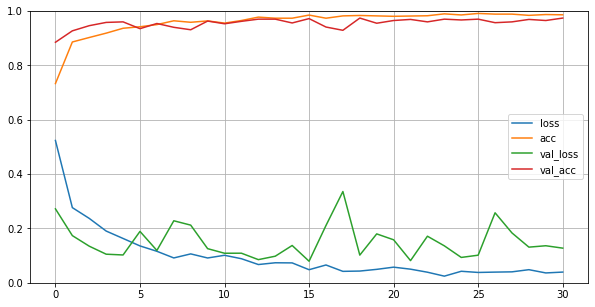

In [21]:
pd.DataFrame(history.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

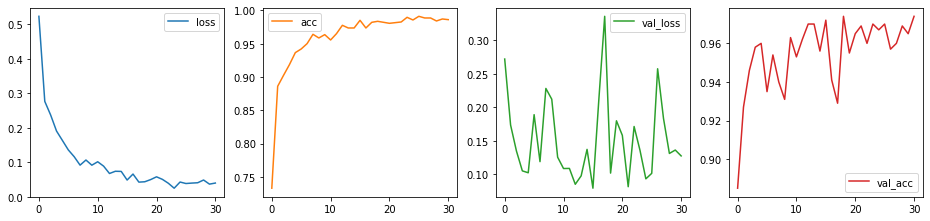

In [22]:
pd.DataFrame(history.history).plot(figsize=(16, 16), layout=(4, 4), subplots=True)
plt.show()

In [23]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1000 images belonging to 2 classes.


In [24]:
ev = model.evaluate(test_generator, steps=50)
ev

50/50 [==============================] - 19s 379ms/step - loss: 0.1048 - acc: 0.9650


[0.10478997975587845, 0.9649999737739563]

In [ ]:
# keras.backend.clear_session
# del model

In [ ]:
# model = keras.models.load_model("project_V04.h5")